In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


🚀 INICIANDO OPTIMIZACIÓN PARA: embeddings_swinv2.csv
1️⃣ Aplicando PCA previo (100 componentes)...
   Dimensiones reducidas: (5600, 100)

2️⃣ Ejecutando Barrido Fino de DBSCAN (Limpieza)...
   Buscando el balance perfecto entre % Limpio y Silhouette...
---------------------------------------------------------------------------
Eps    | % Limpio   | Clusters (GMM)  | Silhouette (Test)
---------------------------------------------------------------------------
4.5    | 80.4     % | 8               | 0.8145
5.0    | 85.5     % | 8               | 0.8065
5.5    | 89.1     % | 8               | 0.7981
6.0    | 91.1     % | 8               | 0.7927
6.5    | 92.4     % | 8               | 0.7877
7.0    | 93.5     % | 8               | 0.7817
7.5    | 94.6     % | 8               | 0.7751
8.0    | 95.6     % | 8               | 0.7683
8.5    | 96.3     % | 8               | 0.7633
9.0    | 97.1     % | 8               | 0.7575
9.5    | 97.8     % | 8               | 0.7512
--------------------

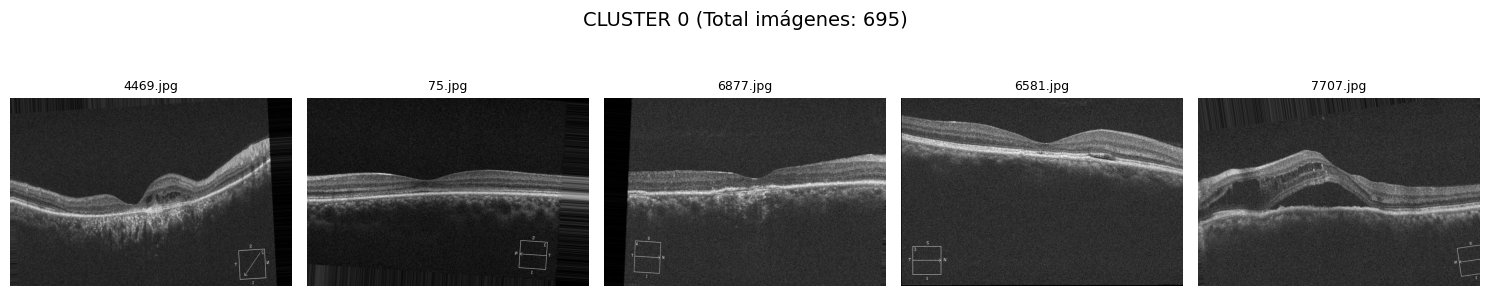

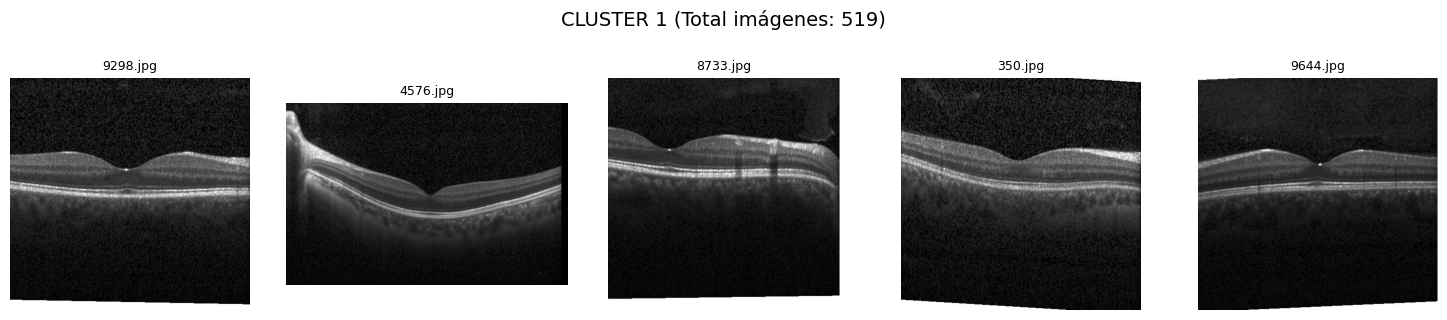

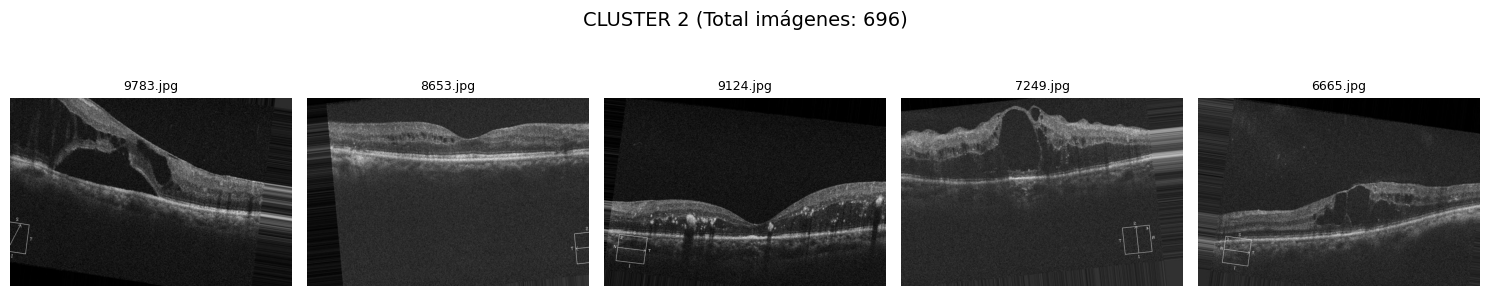

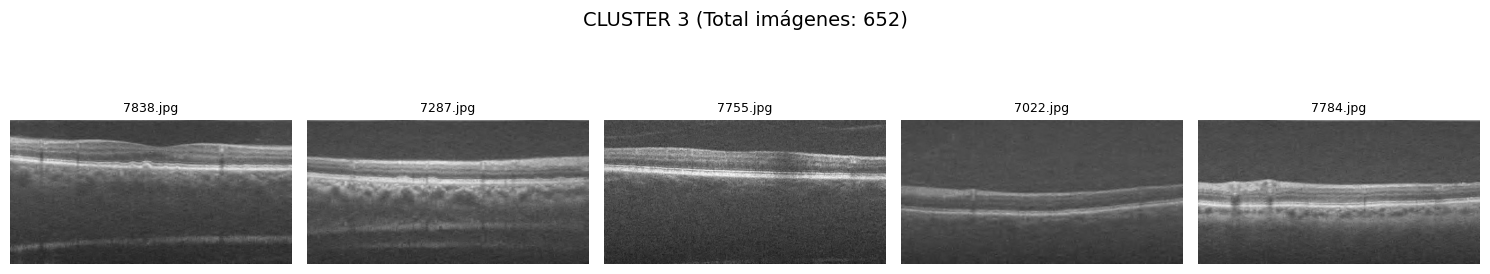

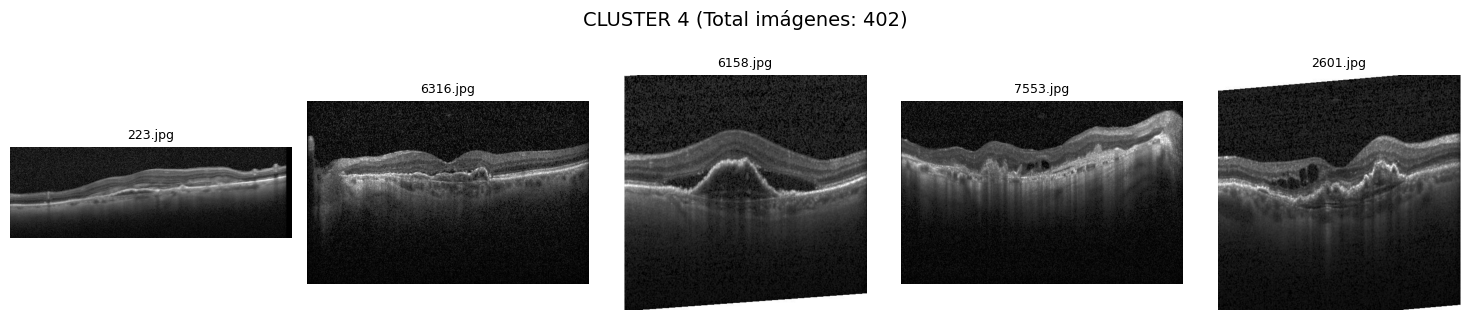

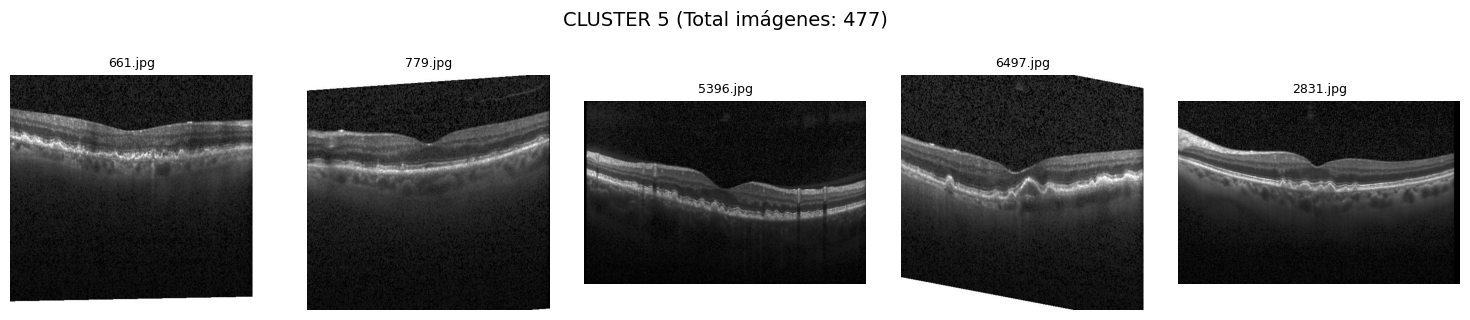

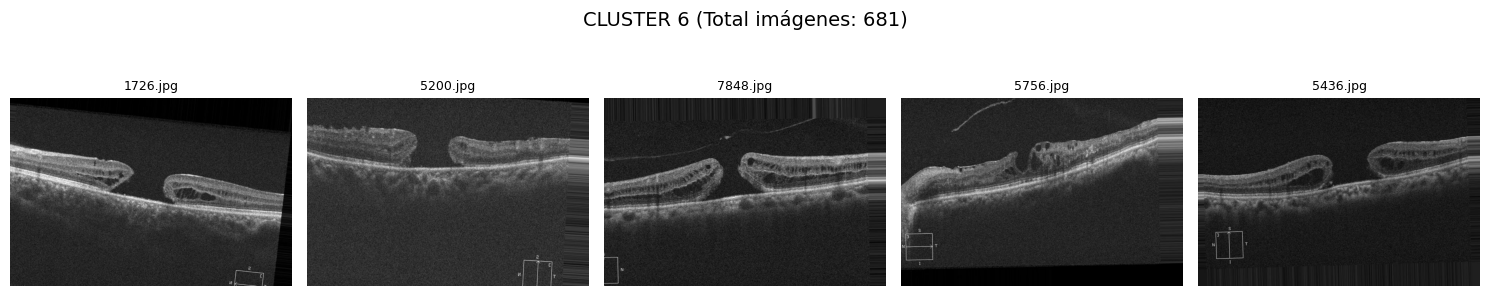

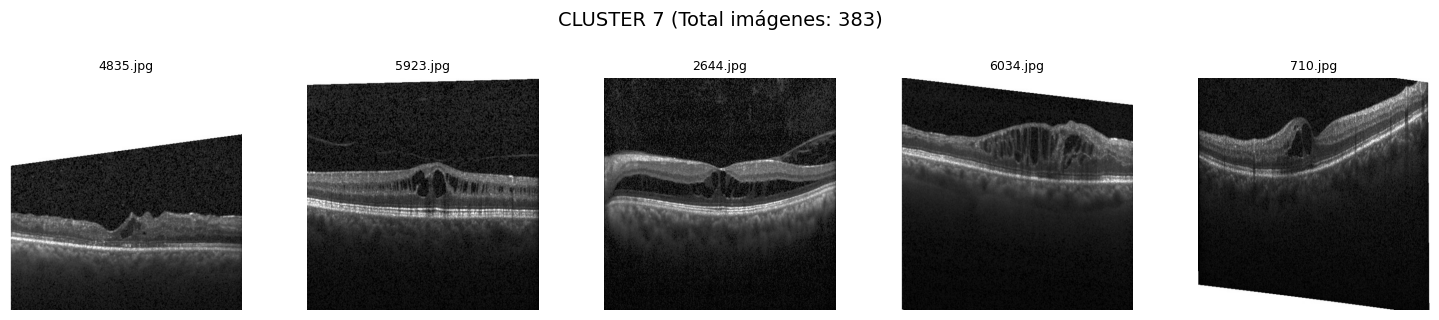

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import random

# ==========================================
# 1. CONFIGURACIÓN (¡CAMBIA ESTO PARA CADA MODELO!)
# ==========================================
# Opciones: "embeddings_resnet50.csv", "embeddings_vit.csv", "embeddings_swin.csv"
csv_file = "embeddings_swinv2.csv"
data_path = "/content/drive/MyDrive/OCTdata/"

print(f"🚀 INICIANDO OPTIMIZACIÓN PARA: {csv_file}")
print("="*60)

# ==========================================
# 2. CARGA Y PREPROCESAMIENTO
# ==========================================
df = pd.read_csv(os.path.join(data_path, csv_file))
img_names = df.iloc[:, 0].values
X_raw = df.iloc[:, 1:].values

# Escalado estándar (Siempre necesario)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# --- TÉCNICA AVANZADA 1: PCA PREVIO ---
print("1️⃣ Aplicando PCA previo (100 componentes)...")
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"   Dimensiones reducidas: {X_pca.shape}")

# ==========================================
# 3. BARRIDO FINO DE LIMPIEZA (DBSCAN)
# ==========================================
print("\n2️⃣ Ejecutando Barrido Fino de DBSCAN (Limpieza)...")
print("   Buscando el balance perfecto entre % Limpio y Silhouette...")
print("-" * 75)
print(f"{'Eps':<6} | {'% Limpio':<10} | {'Clusters (GMM)':<15} | {'Silhouette (Test)':<15}")
print("-" * 75)

eps_range = np.arange(4.0, 16.0, 0.5)
best_score = -1
best_params = {}
best_X_clean = None
best_labels = None
best_labels_dbscan = None  # ← guardamos también las etiquetas DBSCAN de la mejor config

for eps in eps_range:
    # A. Limpieza con DBSCAN
    db = DBSCAN(eps=eps, min_samples=5)
    labels_db = db.fit_predict(X_pca)

    mask = labels_db != -1
    X_clean_temp = X_pca[mask]

    perc_clean = len(X_clean_temp) / len(X_pca) * 100
    if perc_clean < 80 or perc_clean > 98:
        continue

    # B. Test rápido con GMM (k=8)
    try:
        gmm = GaussianMixture(n_components=8, random_state=42)
        labels_gmm = gmm.fit_predict(X_clean_temp)
        sil = silhouette_score(X_clean_temp, labels_gmm)

        print(f"{eps:<6.1f} | {perc_clean:<9.1f}% | {8:<15} | {sil:.4f}")

        if sil > best_score:
            best_score = sil
            best_params = {'eps': eps, 'perc': perc_clean}
            best_X_clean = X_clean_temp
            best_labels = labels_gmm
            best_labels_dbscan = labels_db  # ← guardamos las etiquetas completas
    except:
        continue

print("-" * 75)
print(f"✨ MEJOR CONFIGURACIÓN ENCONTRADA:")
print(f"   Eps: {best_params.get('eps')} | Datos mantenidos: {best_params.get('perc'):.1f}%")
print(f"   Silhouette Preliminar: {best_score:.4f}")

# ==========================================
# 4. RESULTADO FINAL (Con métricas completas)
# ==========================================
if best_X_clean is not None:
    print("\n3️⃣ Calculando métricas finales sobre el dataset optimizado...")

    sil_final = silhouette_score(best_X_clean, best_labels)
    ch_final = calinski_harabasz_score(best_X_clean, best_labels)
    db_final = davies_bouldin_score(best_X_clean, best_labels)

    print("\n" + "="*40)
    print(f"RESULTADOS FINALES PARA {csv_file}")
    print("="*40)
    print(f"Silhouette Score:    {sil_final:.4f}")
    print(f"Calinski-Harabasz:   {ch_final:.2f}")
    print(f"Davies-Bouldin:      {db_final:.4f}")
    print("="*40)

    # ==========================================
    # 5. VALIDACIÓN CUALITATIVA: ANÁLISIS DE IMÁGENES
    # ==========================================
    print("\n4️⃣ Validación cualitativa: muestras de imágenes por cluster...")

    imgs_path = "/content/drive/MyDrive/OCTdata/images/"

    # 1) Máscara de no-ruido usando best_labels_dbscan
    mask_no_ruido = best_labels_dbscan != -1
    img_names_clean = np.array(img_names)[mask_no_ruido]

    print("Tamaños:")
    print("  Total imágenes originales:      ", len(img_names))
    print("  Imágenes tras DBSCAN (no ruido):", len(img_names_clean))
    print("  Filas en best_X_clean:          ", best_X_clean.shape[0])
    print("  Etiquetas GMM (best_labels):    ", len(best_labels))

    # Comprobaciones
    assert best_X_clean.shape[0] == len(best_labels), "best_X_clean y best_labels no coinciden."
    assert len(img_names_clean) == len(best_labels), "img_names_clean y best_labels no coinciden."

    # 2) DataFrame para visualización
    df_resultados_visual = pd.DataFrame({
        'Imagen': img_names_clean,
        'Cluster': best_labels
    })

    # 3) Función auxiliar
    def visualizar_muestras_cluster(cluster_id, df_datos, ruta_imagenes, n_imgs=5):
        """
        Muestra una fila de imágenes pertenecientes a un cluster específico.
        """
        imgs_del_cluster = df_datos[df_datos['Cluster'] == cluster_id]['Imagen'].values

        n = min(n_imgs, len(imgs_del_cluster))
        if n == 0:
            print(f"El Cluster {cluster_id} está vacío.")
            return

        sample_imgs = random.sample(list(imgs_del_cluster), n)

        plt.figure(figsize=(15, 3))
        plt.suptitle(f"CLUSTER {cluster_id} (Total imágenes: {len(imgs_del_cluster)})",
                     fontsize=14, y=1.05)

        for i, img_name in enumerate(sample_imgs):
            plt.subplot(1, n, i+1)
            full_path = os.path.join(ruta_imagenes, img_name)

            try:
                img = Image.open(full_path)
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.title(img_name, fontsize=9)
            except Exception as e:
                plt.text(0.5, 0.5, "Error Carga", ha='center')
                plt.axis('off')
                print(f"Error cargando {img_name}: {e}")

        plt.tight_layout()
        plt.show()

    # 4) Bucle sobre todos los clusters finales (GMM)
    unique_clusters = sorted(df_resultados_visual['Cluster'].unique())
    print(f"--- Visualizando muestras aleatorias de los {len(unique_clusters)} clusters (pipeline PCA+DBSCAN+GMM) ---")

    for c in unique_clusters:
        visualizar_muestras_cluster(c, df_resultados_visual, imgs_path, n_imgs=5)

else:
    print("\n❌ No se encontró una configuración válida. Intenta ampliar el rango de Eps.")



CON PCA
=====================================

 MEJOR CONFIGURACIÓN ENCONTRADA:
 Datos mantenidos: 81.4%

**RESULTADOS FINALES PARA embeddings_vitl16.csv**

Silhouette Score:    0.7761

Calinski-Harabasz:   11112.81

Davies-Bouldin:      0.3245


MEJOR CONFIGURACIÓN ENCONTRADA:
Datos mantenidos: 80.4%

**RESULTADOS FINALES PARA embeddings_swinv2.csv**

Silhouette Score:    0.8145

Calinski-Harabasz:   14396.40

Davies-Bouldin:      0.2857


MEJOR CONFIGURACIÓN ENCONTRADA:
Datos mantenidos: 82.7%

**RESULTADOS FINALES PARA embeddings_resnet50.csv**

Silhouette Score:    0.4399

Calinski-Harabasz:   2409.06

Davies-Bouldin:      0.8978



📊 Generando UMAP 2D para visualización...


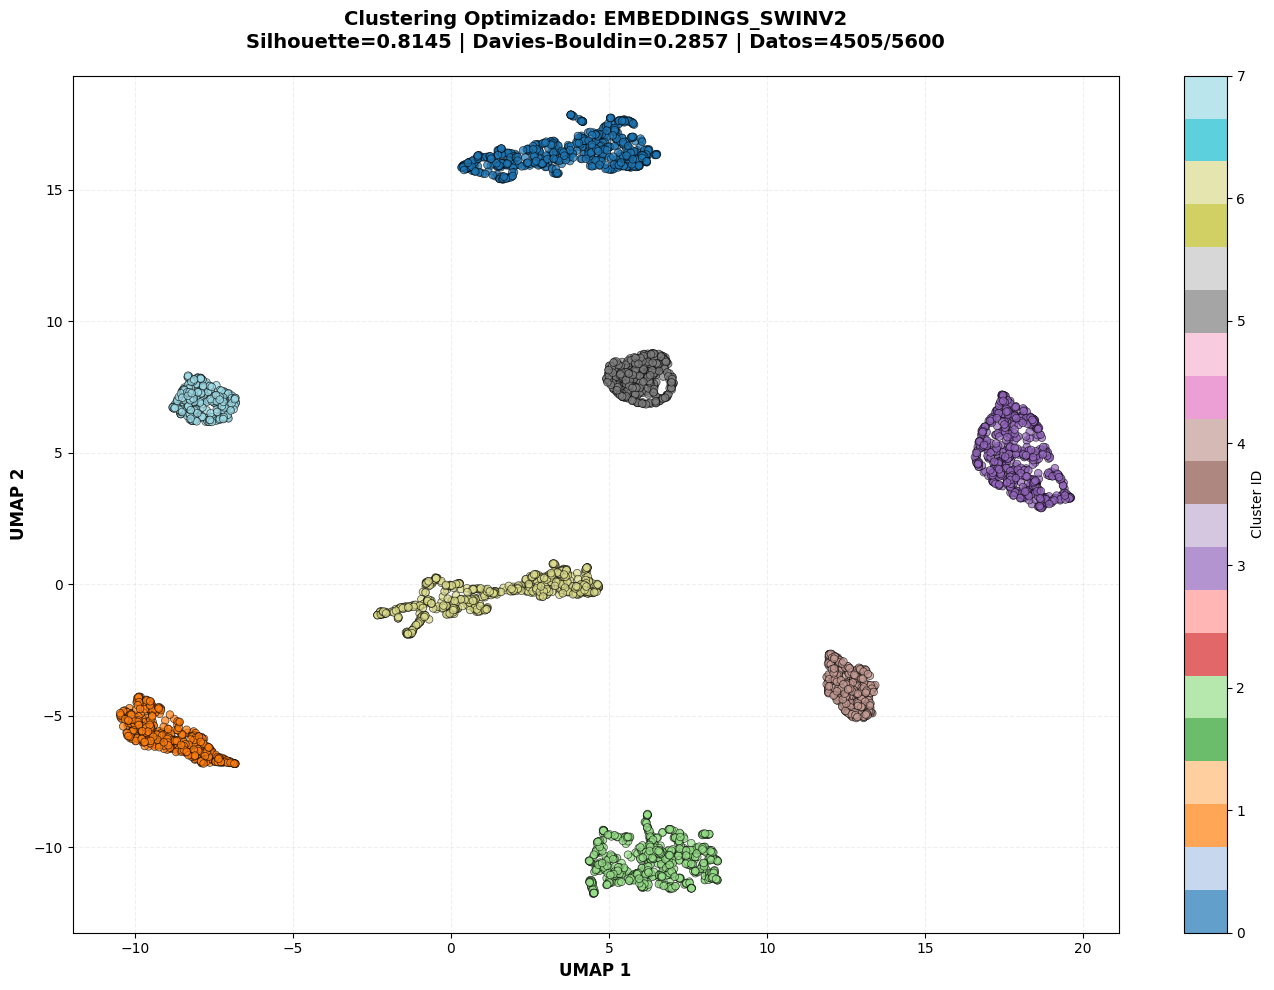

✅ UMAP 2D generado



In [18]:
# ==========================================
# 5. VISUALIZACIÓN 1: UMAP 2D CON CLUSTERS
# ==========================================
print("\n📊 Generando UMAP 2D para visualización...")

import umap

# Calcular UMAP sobre los datos limpios (best_X_clean)
reducer_viz = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap_2d = reducer_viz.fit_transform(best_X_clean)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot con colores por cluster
scatter = ax.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1],
                     c=best_labels, cmap='tab20',
                     s=30, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
ax.set_title(f'Clustering Optimizado: {csv_file.replace(".csv", "").upper()}\n' +
             f'Silhouette={sil_final:.4f} | Davies-Bouldin={db_final:.4f} | Datos={len(best_X_clean)}/{len(X_pca)}',
             fontsize=14, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

print("✅ UMAP 2D generado\n")


In [23]:
# ==========================================
# 6. VISUALIZACIÓN 2: UMAP 3D INTERACTIVO
# ==========================================
print("🎯 Generando UMAP 3D interactivo...")

import umap
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# 1. Calculamos UMAP en 3D (sobre los datos limpios)
reducer_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_umap_3d = reducer_3d.fit_transform(best_X_clean)

# 2. Preparamos DataFrame como en tu ejemplo de referencia
df_3d = pd.DataFrame(X_umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_3d['Cluster'] = best_labels.astype(str)  # clusters como categorías

# 3. Usamos px.scatter_3d para colores y estilo “limpios”
fig_3d = px.scatter_3d(
    df_3d,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='Cluster',
    title=f"UMAP 3D Interactivo: {csv_file.replace('.csv','').upper()}",
    opacity=0.8
)

# Ajuste de tamaño de punto
fig_3d.update_traces(marker=dict(size=3))

# Fondo CLARO y ejes visibles
fig_3d.update_layout(
    title=dict(
        text=f'UMAP 3D Interactivo: {csv_file.replace(".csv", "").upper()}<br>'
             f'<sub>Silhouette={sil_final:.4f} | Davies-Bouldin={db_final:.4f}</sub>',
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3',
        xaxis=dict(backgroundcolor='rgb(245,245,245)'),
        yaxis=dict(backgroundcolor='rgb(245,245,245)'),
        zaxis=dict(backgroundcolor='rgb(245,245,245)')
    ),
    width=1000,
    height=800,
    showlegend=True
)

fig_3d.show()

print("✅ UMAP 3D interactivo generado\n")


🎯 Generando UMAP 3D interactivo...


✅ UMAP 3D interactivo generado

